# **StyleGAN-2 for feature extraction**
This notebook is based on that [GitHub](https://github.com/karray/stylegan2-pytorch/tree/master).

## **Install dependencies**

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-36b430e3-5bd0-5eb1-c17e-607faa40ff24)


In [ ]:
!ninja --version

/bin/bash: line 1: ninja: command not found


In [ ]:
!git clone https://github.com/karray/stylegan2-pytorch/

Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 416, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 416 (delta 5), reused 7 (delta 5), pack-reused 407
Receiving objects: 100% (416/416), 122.53 MiB | 25.97 MiB/s, done.
Resolving deltas: 100% (215/215), done.


In [ ]:
import os
!pip install gdown --upgrade

if os.path.isdir("/content/drive/MyDrive/style-gan-2"):
    %cd "/content/drive/MyDrive/style-gan-2/stylegan2-pytorch"
elif os.path.isdir("/content/drive/"):
    %cd "/content/drive/MyDrive/"
    !mkdir style-gan-2
    %cd style-gan-2
    !git clone https://github.com/karray/stylegan2-pytorch/
    %cd stylegan2-pytorch
    !mkdir downloads
    !mkdir datasets
    !mkdir pretrained
    #!gdown --id 1-5xZkD8ajXw1DdopTkH_rAoCsD72LhKU -O /content/drive/MyDrive/style-gan-2/stylegan2-ada-pytorch/pretrained/wikiart.pkl
else:
    !git clone https://github.com/karray/stylegan2-pytorch/
    %cd stylegan2-pytorch
    !mkdir downloads
    !mkdir datasets
    !mkdir pretrained
    %cd pretrained
    !gdown --id 1-5xZkD8ajXw1DdopTkH_rAoCsD72LhKU
    %cd ../

In [ ]:
!pip uninstall jax jaxlib -y
!pip install "jax[cuda11_cudnn805]==0.3.10" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip uninstall torch torchvision -y
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install timm==0.4.12 ftfy==6.1.1 ninja==1.10.2 opensimplex
!pip install wandb

## **Library imports**

### *Solve minor errors in scripts*

In [ ]:
# to solve name conflict with Python modules
!mv /content/stylegan2-pytorch/distributed.py /content/stylegan2-pytorch/distributed_utils.py

mv: cannot stat '/content/stylegan2-pytorch/distributed.py': No such file or directory


In [ ]:
file_path = '/content/stylegan2-pytorch/non_leaking.py'

with open(file_path, 'r') as file:
    lines = file.readlines()

lines[7] = 'from distributed_utils import reduce_sum\n'

with open(file_path, 'w') as file:
    file.writelines(lines)

In [ ]:
file_path = '/content/stylegan2-pytorch/non_leaking.py'

with open(file_path, 'r') as file:
    lines = file.readlines()

lines[359] = '        op = torch._C._jit_get_operation("aten::grid_sampler_2d_backward")[0]\n'
lines[360] = '        grad_input, grad_grid = op(grad_output, input, grid, 0, 0, False, [True, True])\n'

with open(file_path, 'w') as file:
    file.writelines(lines)

### *Imports*


In [ ]:
import sys
sys.path.append('/content/stylegan2-pytorch/')

In [ ]:
import math
import random
import functools
import operator
import argparse
import os
from os.path import join as ospj
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, autograd, optim
from torch.nn import functional as F
from torch.autograd import Function
from torch.utils import data
import torch.distributed as dist
from torchvision import transforms, utils
from torchvision.datasets import MNIST, CIFAR10

from op import fused_leaky_relu, upfirdn2d, conv2d_gradfix
from model import Generator, Generator1, DiscriminatorMini, MappingNetwork, Encoder
from distributed_utils import get_rank, synchronize, reduce_loss_dict, reduce_sum, get_world_size
from op import conv2d_gradfix
from non_leaking import augment, AdaptiveAugment

import wandb

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


## **Training script**

In [ ]:
def data_sampler(dataset, shuffle, distributed):
    if distributed:
        return data.distributed.DistributedSampler(dataset, shuffle=shuffle)

    if shuffle:
        return data.RandomSampler(dataset)

    else:
        return data.SequentialSampler(dataset)

def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag


def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(par2[k].data, alpha=1 - decay)


def sample_data(loader):
    while True:
        for batch in loader:
            yield batch


def d_logistic_loss(real_pred, fake_pred):
    real_loss = F.softplus(-real_pred)
    fake_loss = F.softplus(fake_pred)

    return real_loss.mean() + fake_loss.mean()


def d_r1_loss(real_pred, real_img):
    with conv2d_gradfix.no_weight_gradients():
        grad_real, = autograd.grad(
            outputs=real_pred.sum(), inputs=real_img, create_graph=True
        )
    grad_penalty = grad_real.pow(2).reshape(grad_real.shape[0], -1).sum(1).mean()

    return grad_penalty


def g_nonsaturating_loss(fake_pred):
    loss = F.softplus(-fake_pred).mean()

    return loss


def g_path_regularize(fake_img, latents, mean_path_length, decay=0.01):
    noise = torch.randn_like(fake_img) / math.sqrt(
        fake_img.shape[2] * fake_img.shape[3]
    )
    grad, = autograd.grad(
        outputs=(fake_img * noise).sum(), inputs=latents, create_graph=True
    )
    path_lengths = torch.sqrt(grad.pow(2).sum(2).mean(1))

    path_mean = mean_path_length + decay * (path_lengths.mean() - mean_path_length)

    path_penalty = (path_lengths - path_mean).pow(2).mean()

    return path_penalty, path_mean.detach(), path_lengths


def make_noise(batch, latent_dim, n_noise, device):
    if n_noise == 1:
        return [torch.randn(batch, latent_dim, device=device)]

    noises = torch.randn(n_noise, batch, latent_dim, device=device).unbind(0)

    return noises


def mixing_noise(batch, latent_dim, prob, device):
    if prob > 0 and random.random() < prob:
        return make_noise(batch, latent_dim, 2, device)

    else:
        return make_noise(batch, latent_dim, 1, device)


def set_grad_none(model, targets):
    for n, p in model.named_parameters():
        if n in targets:
            p.grad = None


def train(args, loader, generator, discriminator,mapping, encoder, g_optim, d_optim, f_optim, e_optim, g_ema, debug_images, debug_z, debug_noise, device,
            sample_dir, working_dir):

    pbar = range(args.iter)

    if get_rank() == 0:
        pbar = tqdm(pbar, initial=args.start_iter, dynamic_ncols=True, smoothing=0.01)

    mean_path_length = 0

    d_loss_val = 0
    r1_loss = torch.tensor(0.0, device=device)
    g_loss_val = 0
    path_loss = torch.tensor(0.0, device=device)
    path_lengths = torch.tensor(0.0, device=device)
    mean_path_length_avg = 0
    loss_dict = {}

    if args.distributed:
        g_module = generator.module
        d_module = discriminator.module
        f_module = mapping.module
        e_module = encoder.module

    else:
        g_module = generator
        d_module = discriminator
        f_module = mapping
        e_module = encoder

    accum = 0.5 ** (32 / (10 * 1000))
    ada_aug_p = args.augment_p if args.augment_p > 0 else 0.0
    r_t_stat = 0

    if args.augment and args.augment_p == 0:
        ada_augment = AdaptiveAugment(args.ada_target, args.ada_length, 8, device)

    for idx in pbar:
        i = idx + args.start_iter

        if i > args.iter:
            print("Done!")
            break

        real_img = next(loader)
        real_img = real_img[0].to(device)

        requires_grad(generator, False)
        requires_grad(mapping, False)
        requires_grad(discriminator, True)
        requires_grad(encoder, True)

        noise = mixing_noise(args.batch, args.latent, args.mixing, device)
        fake_img, _ = generator([mapping(z) for z in noise])

        if args.augment:
            real_img_aug, _ = augment(real_img, ada_aug_p)
            fake_img, _ = augment(fake_img, ada_aug_p)

        else:
            real_img_aug = real_img

        fake_pred = discriminator(encoder(fake_img))
        real_pred = discriminator(encoder(real_img_aug))
        d_loss = d_logistic_loss(real_pred, fake_pred)

        loss_dict["d"] = d_loss
        loss_dict["real_score"] = real_pred.mean()
        loss_dict["fake_score"] = fake_pred.mean()

        discriminator.zero_grad()
        encoder.zero_grad()
        d_loss.backward()
        d_optim.step()
        e_optim.step()

        if args.augment and args.augment_p == 0:
            ada_aug_p = ada_augment.tune(real_pred)
            r_t_stat = ada_augment.r_t_stat

        d_regularize = i % args.d_reg_every == 0

        if d_regularize:
            real_img.requires_grad = True

            if args.augment:
                real_img_aug, _ = augment(real_img, ada_aug_p)

            else:
                real_img_aug = real_img

            real_pred = discriminator(encoder(real_img_aug))
            r1_loss = d_r1_loss(real_pred, real_img)

            discriminator.zero_grad()
            encoder.zero_grad()
            (args.r1 / 2 * r1_loss * args.d_reg_every + 0 * real_pred[0]).backward()

            d_optim.step()
            e_optim.step()

        loss_dict["r1"] = r1_loss

        requires_grad(generator, True)
        requires_grad(mapping, True)
        requires_grad(discriminator, False)
        requires_grad(encoder, False)

        noise = mixing_noise(args.batch, args.latent, args.mixing, device)
        fake_img, _ = generator([mapping(z) for z in noise])

        if args.augment:
            fake_img, _ = augment(fake_img, ada_aug_p)

        fake_pred = discriminator(encoder(fake_img))
        g_loss = g_nonsaturating_loss(fake_pred)

        loss_dict["g"] = g_loss

        generator.zero_grad()
        mapping.zero_grad()
        g_loss.backward()
        g_optim.step()
        f_optim.step()

        g_regularize = i % args.g_reg_every == 0

        if g_regularize:
            path_batch_size = max(1, args.batch // args.path_batch_shrink)
            noise = mixing_noise(path_batch_size, args.latent, args.mixing, device)
            fake_img, latents = generator([mapping(z) for z in noise], return_latents=True)

            path_loss, mean_path_length, path_lengths = g_path_regularize(
                fake_img, latents, mean_path_length
            )

            generator.zero_grad()
            mapping.zero_grad()
            weighted_path_loss = args.path_regularize * args.g_reg_every * path_loss

            if args.path_batch_shrink:
                weighted_path_loss += 0 * fake_img[0, 0, 0, 0]

            weighted_path_loss.backward()

            g_optim.step()
            f_optim.step()

            mean_path_length_avg = (
                reduce_sum(mean_path_length).item() / get_world_size()
            )

        loss_dict["path"] = path_loss
        loss_dict["path_length"] = path_lengths.mean()

        requires_grad(generator, True)
        requires_grad(mapping, True)
        requires_grad(discriminator, False)
        requires_grad(encoder, True)

        w_z = mapping(torch.randn(args.batch, args.latent, device=device))
        fake_img, _ = generator([w_z])
        consitency_loss = (w_z - encoder(fake_img)).pow(2).mean()

        loss_dict["consitency_loss"] = g_loss

        generator.zero_grad()
        mapping.zero_grad()
        encoder.zero_grad()
        consitency_loss.backward()
        g_optim.step()
        f_optim.step()
        e_optim.step()

        accumulate(g_ema, g_module, accum)

        loss_reduced = reduce_loss_dict(loss_dict)

        d_loss_val = loss_reduced["d"].mean().item()
        g_loss_val = loss_reduced["g"].mean().item()
        r1_val = loss_reduced["r1"].mean().item()
        path_loss_val = loss_reduced["path"].mean().item()
        real_score_val = loss_reduced["real_score"].mean().item()
        fake_score_val = loss_reduced["fake_score"].mean().item()
        path_length_val = loss_reduced["path_length"].mean().item()
        w_consitency_loss = loss_reduced["consitency_loss"].mean().item()

        if get_rank() == 0:

            pbar.set_description(
                (
                    f"d: {d_loss_val:.4f}; g: {g_loss_val:.4f}; r1: {r1_val:.4f}; "
                    f"path: {path_loss_val:.4f}; mean path: {mean_path_length_avg:.4f}; "
                    f"augment: {ada_aug_p:.4f}"
                )
            )

            if (i+1) % 100 == 0:

                torch.save(
                    {
                        "g": g_module.state_dict(),
                        "d": d_module.state_dict(),
                        "f": f_module.state_dict(),
                        "e": e_module.state_dict(),
                        "g_ema": g_ema.state_dict(),
                        "g_optim": g_optim.state_dict(),
                        "d_optim": d_optim.state_dict(),
                        "f_optim": f_optim.state_dict(),
                        "e_optim": e_optim.state_dict(),
                        "args": args,
                        "ada_aug_p": ada_aug_p,
                    },
                    ospj(working_dir, f"checkpoint_last.pt"),
                )

                with torch.no_grad():
                    g_ema.eval()

                    debug_img = [debug_images]

                    # reconstruct real images
                    w = encoder(debug_images)
                    images, _ = g_ema([w], noise=debug_noise)
                    debug_img.append(images)

                    # generate from noise
                    w = mapping(debug_z)
                    images, _ = g_ema([w], noise=debug_noise)
                    debug_img.append(images)

                    # reconstruct from noise
                    w = encoder(images)
                    images, _ = g_ema([w], noise=debug_noise)
                    debug_img.append(images)

                    debug_img = torch.cat(debug_img, dim=0)

                    debug_img = debug_img.view(4, 8, 3, 32, 32)
                    debug_img = debug_img.permute(0, 3, 1, 4, 2)
                    debug_img = debug_img.reshape(4 * 32, 8 * 32, 3)

                    debug_img = debug_img.cpu().numpy()

                    plt.figure(figsize=(8, 8))
                    plt.imshow(debug_img)
                    plt.axis('off')
                    plt.show()

## **Define parameters**

In [ ]:
sys.argv = [
    'script_name', '--path', 'data', '--arch', 'stylegan2', '--iter', '10000',
    '--batch', '32', '--n_sample', '64', '--r1', '10', '--path_regularize', '2',
    '--path_batch_shrink', '2', '--d_reg_every', '16', '--g_reg_every', '4',
    '--mixing', '0.9', '--ckpt', 'None', '--lr', '0.002', '--channel_multiplier', '2',
    '--local_rank', '0', '--augment', '--augment_p', '0', '--ada_target', '0.6',
    '--ada_length', '500000', '--ada_every', '256', '--gpu', '0', '--name', 'experiment',
    '--run_name', 'run1'
]

## **Training loop**

load model: /content/drive/MyDrive/Deep Learning/models/checkpoint_final_cifar10_20000.pt
Files already downloaded and verified


  0%|          | 0/10000 [00:00<?, ?it/s]

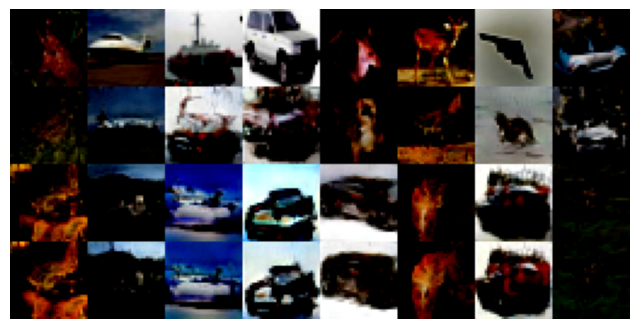

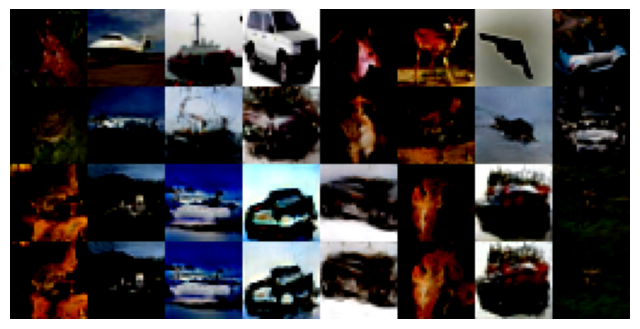

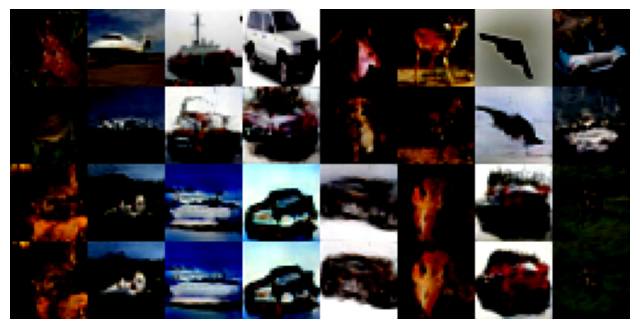

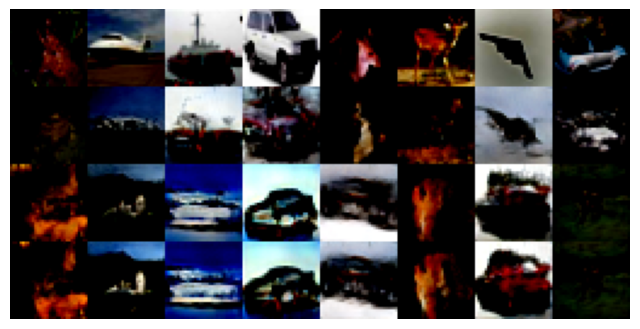

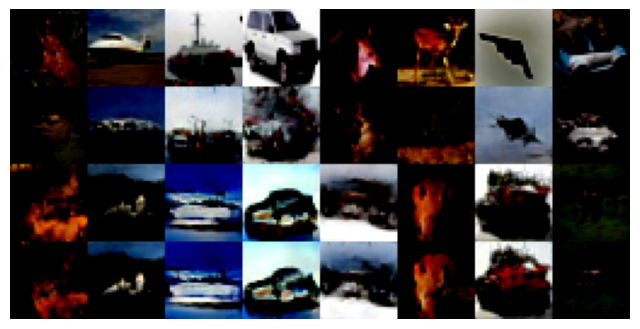

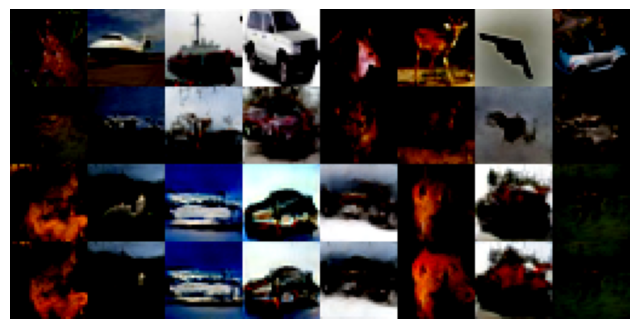

In [ ]:
parser = argparse.ArgumentParser(description="StyleGAN2 trainer")

parser.add_argument("--path", type=str, default='data', help="path to save mnist dataset")
parser.add_argument('--arch', type=str, default='stylegan2', help='model architectures (stylegan2 | swagan)')
parser.add_argument(
    "--iter", type=int, default=800000, help="total training iterations"
)
parser.add_argument(
    "--batch", type=int, default=32, help="batch sizes for each gpus"
)
parser.add_argument(
    "--n_sample",
    type=int,
    default=64,
    help="number of the samples generated during training",
)
parser.add_argument(
    "--r1", type=float, default=10, help="weight of the r1 regularization"
)
parser.add_argument(
    "--path_regularize",
    type=float,
    default=2,
    help="weight of the path length regularization",
)
parser.add_argument(
    "--path_batch_shrink",
    type=int,
    default=2,
    help="batch size reducing factor for the path length regularization (reduce memory consumption)",
)
parser.add_argument(
    "--d_reg_every",
    type=int,
    default=16,
    help="interval of the applying r1 regularization",
)
parser.add_argument(
    "--g_reg_every",
    type=int,
    default=4,
    help="interval of the applying path length regularization",
)
parser.add_argument(
    "--mixing", type=float, default=0.9, help="probability of latent code mixing"
)
parser.add_argument(
    "--ckpt",
    type=str,
    default=None,
    help="path to the checkpoints to resume training",
)
parser.add_argument("--lr", type=float, default=0.002, help="learning rate")
parser.add_argument(
    "--channel_multiplier",
    type=int,
    default=2,
    help="channel multiplier factor for the model. config-f = 2, else = 1",
)
parser.add_argument(
    "--wandb", action="store_true", help="use weights and biases logging"
)
parser.add_argument(
    "--local_rank", type=int, default=0, help="local rank for distributed training"
)
parser.add_argument(
    "--augment", action="store_true", help="apply non leaking augmentation"
)
parser.add_argument(
    "--augment_p",
    type=float,
    default=0,
    help="probability of applying augmentation. 0 = use adaptive augmentation",
)
parser.add_argument(
    "--ada_target",
    type=float,
    default=0.6,
    help="target augmentation probability for adaptive augmentation",
)
parser.add_argument(
    "--ada_length",
    type=int,
    default=500 * 1000,
    help="target duraing to reach augmentation probability for adaptive augmentation",
)
parser.add_argument(
    "--ada_every",
    type=int,
    default=256,
    help="probability update interval of the adaptive augmentation",
)

parser.add_argument("--gpu", type=str, help="GPU ID")
parser.add_argument("--name", type=str, help="Experiment name")
parser.add_argument("--run_name", type=str, help="Run name")

args = parser.parse_args()

device = f'cuda:{args.gpu}'

n_gpu = int(os.environ["WORLD_SIZE"]) if "WORLD_SIZE" in os.environ else 1
args.distributed = n_gpu > 1

if args.distributed:
    torch.cuda.set_device(args.local_rank)
    torch.distributed.init_process_group(backend="nccl", init_method="env://")
    synchronize()

args.latent = 128
args.n_mlp = 8
args.size = 32

args.start_iter = 0

generator = Generator1(
    args.size, args.latent, channel_multiplier=args.channel_multiplier
).to(device)
mapping = MappingNetwork(args.latent, args.n_mlp,).to(device)
discriminator = DiscriminatorMini(args.latent).to(device)
encoder = Encoder(args.size, args.latent).to(device)
g_ema = Generator1(
    args.size, args.latent, channel_multiplier=args.channel_multiplier
).to(device)
g_ema.eval()
accumulate(g_ema, generator, 0)

g_reg_ratio = args.g_reg_every / (args.g_reg_every + 1)
d_reg_ratio = args.d_reg_every / (args.d_reg_every + 1)

g_optim = optim.Adam(
    generator.parameters(),
    lr=args.lr * g_reg_ratio,
    betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio),
)
d_optim = optim.Adam(
    discriminator.parameters(),
    lr=args.lr * d_reg_ratio,
    betas=(0 ** d_reg_ratio, 0.99 ** d_reg_ratio),
)
f_optim = optim.Adam(
    mapping.parameters(),
    lr=args.lr * g_reg_ratio,
    betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio),
)
e_optim = optim.Adam(
    encoder.parameters(),
    lr=args.lr * d_reg_ratio,
    betas=(0 ** d_reg_ratio, 0.99 ** d_reg_ratio),
)

if args.ckpt != 'None':
    print("load model:", args.ckpt)

    ckpt = torch.load(args.ckpt)

    try:
        ckpt_name = os.path.basename(args.ckpt)
        args.start_iter = int(os.path.splitext(ckpt_name)[0])

    except ValueError:
        pass

    generator.load_state_dict(ckpt["g"])
    discriminator.load_state_dict(ckpt["d"])
    mapping.load_state_dict(ckpt["f"])
    encoder.load_state_dict(ckpt["e"])
    g_ema.load_state_dict(ckpt["g_ema"])

    g_optim.load_state_dict(ckpt["g_optim"])
    d_optim.load_state_dict(ckpt["d_optim"])
    f_optim.load_state_dict(ckpt["f_optim"])
    e_optim.load_state_dict(ckpt["e_optim"])

if args.distributed:
    generator = nn.parallel.DistributedDataParallel(
        generator,
        device_ids=[args.local_rank],
        output_device=args.local_rank,
        broadcast_buffers=False,
    )

    discriminator = nn.parallel.DistributedDataParallel(
        discriminator,
        device_ids=[args.local_rank],
        output_device=args.local_rank,
        broadcast_buffers=False,
    )

    mapping = nn.parallel.DistributedDataParallel(
        mapping,
        device_ids=[args.local_rank],
        output_device=args.local_rank,
        broadcast_buffers=False,
    )

    encoder = nn.parallel.DistributedDataParallel(
        encoder,
        device_ids=[args.local_rank],
        output_device=args.local_rank,
        broadcast_buffers=False,
    )

transform = transforms.Compose(
    [
        transforms.Grayscale(3),
        transforms.Pad(2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,), inplace=True),
    ]
)

dataset = CIFAR10(root=args.path, train=True, download=True, transform=transform)

loader = data.DataLoader(
    dataset,
    batch_size=args.batch,
    sampler=data_sampler(dataset, shuffle=True, distributed=args.distributed),
    drop_last=True,
)
loader = sample_data(loader)

debug_images = next(loader)[0][:8].to(device)
debug_noise = generator.make_noise()
debug_z = torch.randn(8, args.latent, device=device)

args.wandb = False
args.wandb


if get_rank() == 0 and wandb is not None and args.wandb:
    wandb.init(project=args.name)
    wandb.run.name = args.run_name
    wandb.run.save()

if not os.path.exists('results'):
    os.mkdir('results')
working_dir = ospj('results', f'{args.name}_{args.run_name}')
if not os.path.exists(working_dir):
    os.mkdir(working_dir)

sample_dir = ospj(working_dir, 'samples')
if not os.path.exists(sample_dir):
    os.mkdir(sample_dir)

working_dir = working_dir

images = train(args, loader, generator, discriminator, mapping, encoder, g_optim, d_optim, f_optim, e_optim, g_ema, debug_images, debug_z, debug_noise, device,
        sample_dir, working_dir)

## **Umap feature vizualization**

In [ ]:
!pip install umap-learn

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
import umap

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from umap import UMAP

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5071, 0.4867, 0.4408], [0.2675, 0.2565, 0.2761])
])

dataset = CIFAR10(root=args.path, train=False, download=True, transform=transform)
sampler = SubsetRandomSampler(range(10000))
dataloader_small = DataLoader(dataset, batch_size=1000, sampler=sampler)

encoder.eval()
encoder.to(device)

features_list = []
labels_list = []

for images, labels in dataloader_small:
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        features = encoder(images)

    features_list.append(features.cpu().detach().numpy())
    labels_list.append(labels.cpu().detach().numpy())

features_array = np.concatenate(features_list, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

/content/drive/MyDrive/Deep Learning/gan_utilities/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.3.0+cu121. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


## **2D-projection**

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


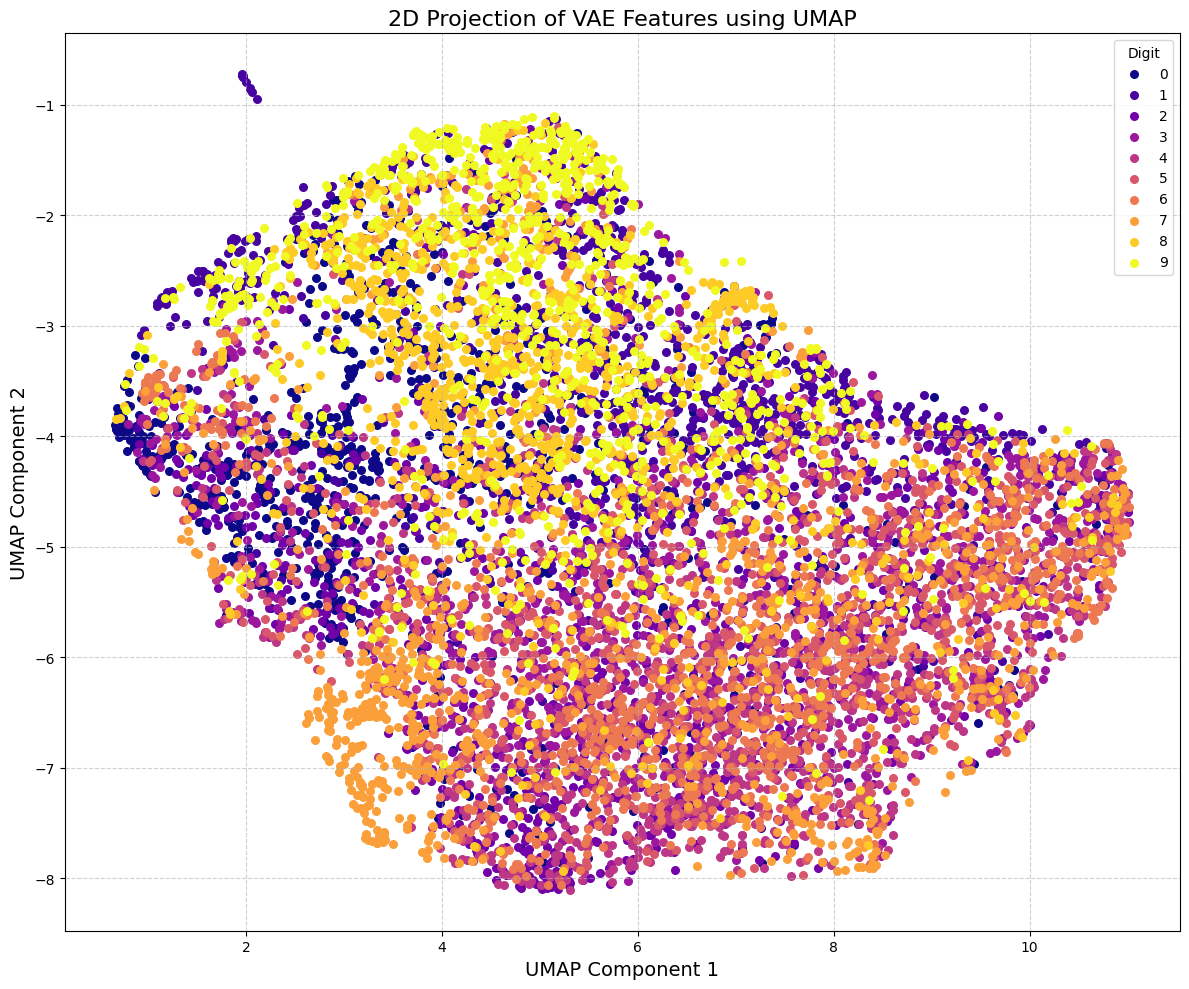

In [ ]:
scaler = MinMaxScaler()
y = labels_array
X_scaled = scaler.fit_transform(features_array)

X_umap = umap.UMAP(n_components=2, random_state=1).fit_transform(X_scaled)

colors = [
 '#0d0887',
 '#46039f',
 '#7201a8',
 '#9c179e',
 '#bd3786',
 '#d8576b',
 '#ed7953',
 '#fb9f3a',
 '#fdca26',
 '#f0f921']

plt.figure(figsize=(12, 10))
for i in range(10):
    plt.scatter(X_umap[y == i, 0], X_umap[y == i, 1], color=colors[i], label=str(i), s=30)
plt.xlabel('UMAP Component 1', fontsize=14)
plt.ylabel('UMAP Component 2', fontsize=14)
plt.title('2D Projection of VAE Features using UMAP', fontsize=16)
plt.legend(title='Digit', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('umap_projection.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
np.save('features-cifar-100', features_array)

In [ ]:
np.save('labels-cifar-100', labels_array)

## **Small Net training**

Training a simple two-layer neural network on features obtained from a generative GAN model. Analyzing model accuracy based on varying the number of images per class.

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, num_classes, hidden_dim=128):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
        self.input_size = input_size
        self.num_classes = num_classes

    def forward(self, x):
        return self.model(x)

In [ ]:
def extract_features(images, labels, encoder):
    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        features = encoder(images)
    return features


def train_model(train_loader, model, criterion, optimizer, encoder, epochs=90, loss_list=[]):
    model.train()
    loss_list = []
    for epoch in tqdm(range(1, epochs+1)):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            features = extract_features(images, labels, encoder)
            outputs = model(features)
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss / len(train_loader))
        print(f"Epoch {epoch}, Loss: {running_loss / len(train_loader):.3f}")
        '''if epoch % 10 == 0:
            accuracy = test_model(model, test_loader, encoder)
            print(f"Accuracy {accuracy}%")'''
    return loss_list


def test_model(model, test_loader, encoder):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            features = torch.tensor(extract_features(images, labels, encoder)).to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
n_classes = 10
batch_size = 4
input_size = 128
hidden_size = 32
n_samples = 16

In [ ]:
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

class_indices = [[] for _ in range(n_classes)]
for idx, (_, label) in enumerate(train_dataset):
    class_indices[label].append(idx)

selected_indices = []
for indices in class_indices:
    selected_indices.extend(indices[:n_samples])

sampler = SubsetRandomSampler(selected_indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
accuracies = {}

In [ ]:
epochs_all = [300, 300, 300, 300, 300, 200, 200, 200]
dataset_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
batch_sizes = [4, 4, 4, 8, 8, 16, 32, 64, 64, 64, 128]

for dataset_size, epochs in zip(dataset_sizes, epochs_all):
    print(f'--------- CALCULATIONS FOR dataset_size={dataset_size} ---------')

    selected_indices = []
    for indices in class_indices:
        selected_indices.extend(indices[:dataset_size])

    sampler = SubsetRandomSampler(selected_indices)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

    model = Net(input_size, n_classes, hidden_dim=hidden_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_list = train_model(train_loader, model, criterion, optimizer, encoder, epochs=epochs)
    accuracy = test_model(model, test_loader, encoder)

    print(f'accuracy = {accuracy}%')
    accuracies[dataset_size] = accuracy

--------- CALCULATIONS FOR dataset_size=2 ---------


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1, Loss: 2.312
Epoch 2, Loss: 2.283
Epoch 3, Loss: 2.266
Epoch 4, Loss: 2.246
Epoch 5, Loss: 2.228
Epoch 6, Loss: 2.213
Epoch 7, Loss: 2.198
Epoch 8, Loss: 2.183
Epoch 9, Loss: 2.164
Epoch 10, Loss: 2.147
Epoch 11, Loss: 2.127
Epoch 12, Loss: 2.110
Epoch 13, Loss: 2.090
Epoch 14, Loss: 2.070
Epoch 15, Loss: 2.052
Epoch 16, Loss: 2.024
Epoch 17, Loss: 2.004
Epoch 18, Loss: 1.986
Epoch 19, Loss: 1.961
Epoch 20, Loss: 1.935
Epoch 21, Loss: 1.910
Epoch 22, Loss: 1.890
Epoch 23, Loss: 1.861
Epoch 24, Loss: 1.840
Epoch 25, Loss: 1.822
Epoch 26, Loss: 1.786
Epoch 27, Loss: 1.762
Epoch 28, Loss: 1.734
Epoch 29, Loss: 1.717
Epoch 30, Loss: 1.687
Epoch 31, Loss: 1.656
Epoch 32, Loss: 1.632
Epoch 33, Loss: 1.608
Epoch 34, Loss: 1.584
Epoch 35, Loss: 1.562
Epoch 36, Loss: 1.520
Epoch 37, Loss: 1.489
Epoch 38, Loss: 1.479
Epoch 39, Loss: 1.447
Epoch 40, Loss: 1.422
Epoch 41, Loss: 1.396
Epoch 42, Loss: 1.380
Epoch 43, Loss: 1.342
Epoch 44, Loss: 1.323
Epoch 45, Loss: 1.307
Epoch 46, Loss: 1.2

  0%|          | 0/2500 [00:00<?, ?it/s]

<ipython-input-26-3515c6ecc82a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(extract_features(images, labels, encoder)).to(device)


accuracy = 26.68%
--------- CALCULATIONS FOR dataset_size=4 ---------


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1, Loss: 2.316
Epoch 2, Loss: 2.289
Epoch 3, Loss: 2.272
Epoch 4, Loss: 2.258
Epoch 5, Loss: 2.242
Epoch 6, Loss: 2.227
Epoch 7, Loss: 2.209
Epoch 8, Loss: 2.188
Epoch 9, Loss: 2.164
Epoch 10, Loss: 2.141
Epoch 11, Loss: 2.116
Epoch 12, Loss: 2.093
Epoch 13, Loss: 2.065
Epoch 14, Loss: 2.039
Epoch 15, Loss: 2.014
Epoch 16, Loss: 1.983
Epoch 17, Loss: 1.957
Epoch 18, Loss: 1.927
Epoch 19, Loss: 1.904
Epoch 20, Loss: 1.867
Epoch 21, Loss: 1.845
Epoch 22, Loss: 1.814
Epoch 23, Loss: 1.785
Epoch 24, Loss: 1.759
Epoch 25, Loss: 1.731
Epoch 26, Loss: 1.700
Epoch 27, Loss: 1.677
Epoch 28, Loss: 1.648
Epoch 29, Loss: 1.619
Epoch 30, Loss: 1.587
Epoch 31, Loss: 1.567
Epoch 32, Loss: 1.545
Epoch 33, Loss: 1.515
Epoch 34, Loss: 1.491
Epoch 35, Loss: 1.473
Epoch 36, Loss: 1.444
Epoch 37, Loss: 1.425
Epoch 38, Loss: 1.403
Epoch 39, Loss: 1.388
Epoch 40, Loss: 1.365
Epoch 41, Loss: 1.344
Epoch 42, Loss: 1.323
Epoch 43, Loss: 1.307
Epoch 44, Loss: 1.288
Epoch 45, Loss: 1.269
Epoch 46, Loss: 1.2

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 31.27%
--------- CALCULATIONS FOR dataset_size=8 ---------


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1, Loss: 2.302
Epoch 2, Loss: 2.273
Epoch 3, Loss: 2.252
Epoch 4, Loss: 2.221
Epoch 5, Loss: 2.189
Epoch 6, Loss: 2.157
Epoch 7, Loss: 2.121
Epoch 8, Loss: 2.083
Epoch 9, Loss: 2.045
Epoch 10, Loss: 2.005
Epoch 11, Loss: 1.966
Epoch 12, Loss: 1.934
Epoch 13, Loss: 1.889
Epoch 14, Loss: 1.843
Epoch 15, Loss: 1.806
Epoch 16, Loss: 1.771
Epoch 17, Loss: 1.742
Epoch 18, Loss: 1.704
Epoch 19, Loss: 1.673
Epoch 20, Loss: 1.649
Epoch 21, Loss: 1.611
Epoch 22, Loss: 1.586
Epoch 23, Loss: 1.567
Epoch 24, Loss: 1.530
Epoch 25, Loss: 1.517
Epoch 26, Loss: 1.480
Epoch 27, Loss: 1.458
Epoch 28, Loss: 1.443
Epoch 29, Loss: 1.427
Epoch 30, Loss: 1.405
Epoch 31, Loss: 1.383
Epoch 32, Loss: 1.361
Epoch 33, Loss: 1.339
Epoch 34, Loss: 1.332
Epoch 35, Loss: 1.317
Epoch 36, Loss: 1.290
Epoch 37, Loss: 1.277
Epoch 38, Loss: 1.246
Epoch 39, Loss: 1.236
Epoch 40, Loss: 1.235
Epoch 41, Loss: 1.217
Epoch 42, Loss: 1.195
Epoch 43, Loss: 1.201
Epoch 44, Loss: 1.175
Epoch 45, Loss: 1.155
Epoch 46, Loss: 1.1

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 33.16%
--------- CALCULATIONS FOR dataset_size=16 ---------


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1, Loss: 2.295
Epoch 2, Loss: 2.230
Epoch 3, Loss: 2.170
Epoch 4, Loss: 2.110
Epoch 5, Loss: 2.055
Epoch 6, Loss: 1.985
Epoch 7, Loss: 1.931
Epoch 8, Loss: 1.881
Epoch 9, Loss: 1.821
Epoch 10, Loss: 1.772
Epoch 11, Loss: 1.726
Epoch 12, Loss: 1.692
Epoch 13, Loss: 1.649
Epoch 14, Loss: 1.638
Epoch 15, Loss: 1.583
Epoch 16, Loss: 1.550
Epoch 17, Loss: 1.537
Epoch 18, Loss: 1.512
Epoch 19, Loss: 1.485
Epoch 20, Loss: 1.463
Epoch 21, Loss: 1.450
Epoch 22, Loss: 1.426
Epoch 23, Loss: 1.408
Epoch 24, Loss: 1.384
Epoch 25, Loss: 1.376
Epoch 26, Loss: 1.352
Epoch 27, Loss: 1.344
Epoch 28, Loss: 1.319
Epoch 29, Loss: 1.311
Epoch 30, Loss: 1.295
Epoch 31, Loss: 1.281
Epoch 32, Loss: 1.267
Epoch 33, Loss: 1.251
Epoch 34, Loss: 1.242
Epoch 35, Loss: 1.235
Epoch 36, Loss: 1.223
Epoch 37, Loss: 1.214
Epoch 38, Loss: 1.190
Epoch 39, Loss: 1.186
Epoch 40, Loss: 1.163
Epoch 41, Loss: 1.172
Epoch 42, Loss: 1.153
Epoch 43, Loss: 1.143
Epoch 44, Loss: 1.121
Epoch 45, Loss: 1.126
Epoch 46, Loss: 1.1

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 38.88%
--------- CALCULATIONS FOR dataset_size=32 ---------


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1, Loss: 2.280
Epoch 2, Loss: 2.199
Epoch 3, Loss: 2.082
Epoch 4, Loss: 1.966
Epoch 5, Loss: 1.868
Epoch 6, Loss: 1.779
Epoch 7, Loss: 1.709
Epoch 8, Loss: 1.649
Epoch 9, Loss: 1.595
Epoch 10, Loss: 1.556
Epoch 11, Loss: 1.513
Epoch 12, Loss: 1.490
Epoch 13, Loss: 1.459
Epoch 14, Loss: 1.433
Epoch 15, Loss: 1.415
Epoch 16, Loss: 1.401
Epoch 17, Loss: 1.383
Epoch 18, Loss: 1.366
Epoch 19, Loss: 1.357
Epoch 20, Loss: 1.332
Epoch 21, Loss: 1.322
Epoch 22, Loss: 1.296
Epoch 23, Loss: 1.298
Epoch 24, Loss: 1.279
Epoch 25, Loss: 1.274
Epoch 26, Loss: 1.254
Epoch 27, Loss: 1.250
Epoch 28, Loss: 1.239
Epoch 29, Loss: 1.237
Epoch 30, Loss: 1.208
Epoch 31, Loss: 1.208
Epoch 32, Loss: 1.207
Epoch 33, Loss: 1.180
Epoch 34, Loss: 1.180
Epoch 35, Loss: 1.172
Epoch 36, Loss: 1.158
Epoch 37, Loss: 1.155
Epoch 38, Loss: 1.157
Epoch 39, Loss: 1.143
Epoch 40, Loss: 1.124
Epoch 41, Loss: 1.116
Epoch 42, Loss: 1.123
Epoch 43, Loss: 1.106
Epoch 44, Loss: 1.100
Epoch 45, Loss: 1.104
Epoch 46, Loss: 1.0

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 43.55%
--------- CALCULATIONS FOR dataset_size=64 ---------


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, Loss: 2.230
Epoch 2, Loss: 1.986
Epoch 3, Loss: 1.804
Epoch 4, Loss: 1.701
Epoch 5, Loss: 1.631
Epoch 6, Loss: 1.577
Epoch 7, Loss: 1.551
Epoch 8, Loss: 1.525
Epoch 9, Loss: 1.496
Epoch 10, Loss: 1.463
Epoch 11, Loss: 1.459
Epoch 12, Loss: 1.437
Epoch 13, Loss: 1.423
Epoch 14, Loss: 1.405
Epoch 15, Loss: 1.385
Epoch 16, Loss: 1.386
Epoch 17, Loss: 1.364
Epoch 18, Loss: 1.364
Epoch 19, Loss: 1.348
Epoch 20, Loss: 1.330
Epoch 21, Loss: 1.316
Epoch 22, Loss: 1.308
Epoch 23, Loss: 1.298
Epoch 24, Loss: 1.282
Epoch 25, Loss: 1.284
Epoch 26, Loss: 1.260
Epoch 27, Loss: 1.258
Epoch 28, Loss: 1.247
Epoch 29, Loss: 1.242
Epoch 30, Loss: 1.244
Epoch 31, Loss: 1.221
Epoch 32, Loss: 1.214
Epoch 33, Loss: 1.200
Epoch 34, Loss: 1.196
Epoch 35, Loss: 1.184
Epoch 36, Loss: 1.191
Epoch 37, Loss: 1.184
Epoch 38, Loss: 1.170
Epoch 39, Loss: 1.144
Epoch 40, Loss: 1.154
Epoch 41, Loss: 1.139
Epoch 42, Loss: 1.133
Epoch 43, Loss: 1.128
Epoch 44, Loss: 1.120
Epoch 45, Loss: 1.114
Epoch 46, Loss: 1.1

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 47.45%
--------- CALCULATIONS FOR dataset_size=128 ---------


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, Loss: 2.166
Epoch 2, Loss: 1.805
Epoch 3, Loss: 1.645
Epoch 4, Loss: 1.577
Epoch 5, Loss: 1.532
Epoch 6, Loss: 1.504
Epoch 7, Loss: 1.476
Epoch 8, Loss: 1.451
Epoch 9, Loss: 1.435
Epoch 10, Loss: 1.412
Epoch 11, Loss: 1.398
Epoch 12, Loss: 1.378
Epoch 13, Loss: 1.364
Epoch 14, Loss: 1.351
Epoch 15, Loss: 1.332
Epoch 16, Loss: 1.325
Epoch 17, Loss: 1.304
Epoch 18, Loss: 1.300
Epoch 19, Loss: 1.290
Epoch 20, Loss: 1.279
Epoch 21, Loss: 1.270
Epoch 22, Loss: 1.260
Epoch 23, Loss: 1.252
Epoch 24, Loss: 1.234
Epoch 25, Loss: 1.233
Epoch 26, Loss: 1.221
Epoch 27, Loss: 1.215
Epoch 28, Loss: 1.200
Epoch 29, Loss: 1.199
Epoch 30, Loss: 1.183
Epoch 31, Loss: 1.178
Epoch 32, Loss: 1.176
Epoch 33, Loss: 1.167
Epoch 34, Loss: 1.149
Epoch 35, Loss: 1.150
Epoch 36, Loss: 1.151
Epoch 37, Loss: 1.139
Epoch 38, Loss: 1.143
Epoch 39, Loss: 1.124
Epoch 40, Loss: 1.114
Epoch 41, Loss: 1.114
Epoch 42, Loss: 1.107
Epoch 43, Loss: 1.097
Epoch 44, Loss: 1.083
Epoch 45, Loss: 1.082
Epoch 46, Loss: 1.0

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 50.66%
--------- CALCULATIONS FOR dataset_size=256 ---------


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, Loss: 2.033
Epoch 2, Loss: 1.654
Epoch 3, Loss: 1.550


KeyboardInterrupt: 

In [ ]:
accuracies

{2: 26.68, 4: 31.27, 8: 33.16, 16: 38.88, 32: 43.55, 64: 47.45, 128: 50.66}

In [ ]:
epochs_all = [200, 200, 200]
dataset_sizes = [256, 512, 1024]
batch_sizes = [64, 64, 128]

for dataset_size, epochs in zip(dataset_sizes, epochs_all):
    print(f'--------- CALCULATIONS FOR dataset_size={dataset_size} ---------')

    selected_indices = []
    for indices in class_indices:
        selected_indices.extend(indices[:dataset_size])

    sampler = SubsetRandomSampler(selected_indices)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

    model = Net(input_size, n_classes, hidden_dim=hidden_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_list = train_model(train_loader, model, criterion, optimizer, encoder, epochs=epochs)
    accuracy = test_model(model, test_loader, encoder)

    print(f'accuracy = {accuracy}%')
    accuracies[dataset_size] = accuracy

--------- CALCULATIONS FOR dataset_size=256 ---------


  0%|          | 0/200 [00:00<?, ?it/s]

/content/drive/MyDrive/Deep Learning/gan_utilities/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.3.0+cu121. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


Epoch 1, Loss: 1.980
Epoch 2, Loss: 1.638
Epoch 3, Loss: 1.540
Epoch 4, Loss: 1.480
Epoch 5, Loss: 1.451
Epoch 6, Loss: 1.420
Epoch 7, Loss: 1.388
Epoch 8, Loss: 1.368
Epoch 9, Loss: 1.352
Epoch 10, Loss: 1.334
Epoch 11, Loss: 1.319
Epoch 12, Loss: 1.303
Epoch 13, Loss: 1.288
Epoch 14, Loss: 1.279
Epoch 15, Loss: 1.272
Epoch 16, Loss: 1.256
Epoch 17, Loss: 1.242
Epoch 18, Loss: 1.237
Epoch 19, Loss: 1.233
Epoch 20, Loss: 1.216
Epoch 21, Loss: 1.204
Epoch 22, Loss: 1.200
Epoch 23, Loss: 1.188
Epoch 24, Loss: 1.184
Epoch 25, Loss: 1.174
Epoch 26, Loss: 1.168
Epoch 27, Loss: 1.156
Epoch 28, Loss: 1.153
Epoch 29, Loss: 1.151
Epoch 30, Loss: 1.144
Epoch 31, Loss: 1.133
Epoch 32, Loss: 1.133
Epoch 33, Loss: 1.123
Epoch 34, Loss: 1.120
Epoch 35, Loss: 1.111
Epoch 36, Loss: 1.108
Epoch 37, Loss: 1.099
Epoch 38, Loss: 1.101
Epoch 39, Loss: 1.094
Epoch 40, Loss: 1.091
Epoch 41, Loss: 1.089
Epoch 42, Loss: 1.073
Epoch 43, Loss: 1.073
Epoch 44, Loss: 1.069
Epoch 45, Loss: 1.064
Epoch 46, Loss: 1.0

  0%|          | 0/2500 [00:00<?, ?it/s]

<ipython-input-20-3515c6ecc82a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(extract_features(images, labels, encoder)).to(device)


accuracy = 55.65%
--------- CALCULATIONS FOR dataset_size=512 ---------


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, Loss: 1.838
Epoch 2, Loss: 1.563
Epoch 3, Loss: 1.489
Epoch 4, Loss: 1.435
Epoch 5, Loss: 1.397
Epoch 6, Loss: 1.362
Epoch 7, Loss: 1.339
Epoch 8, Loss: 1.316
Epoch 9, Loss: 1.297
Epoch 10, Loss: 1.280
Epoch 11, Loss: 1.263
Epoch 12, Loss: 1.247
Epoch 13, Loss: 1.235
Epoch 14, Loss: 1.221
Epoch 15, Loss: 1.214
Epoch 16, Loss: 1.200
Epoch 17, Loss: 1.192
Epoch 18, Loss: 1.183
Epoch 19, Loss: 1.178
Epoch 20, Loss: 1.167
Epoch 21, Loss: 1.161
Epoch 22, Loss: 1.156
Epoch 23, Loss: 1.145
Epoch 24, Loss: 1.140
Epoch 25, Loss: 1.136
Epoch 26, Loss: 1.129
Epoch 27, Loss: 1.121
Epoch 28, Loss: 1.116
Epoch 29, Loss: 1.109
Epoch 30, Loss: 1.107
Epoch 31, Loss: 1.103
Epoch 32, Loss: 1.093
Epoch 33, Loss: 1.094
Epoch 34, Loss: 1.087
Epoch 35, Loss: 1.087
Epoch 36, Loss: 1.079
Epoch 37, Loss: 1.075
Epoch 38, Loss: 1.076
Epoch 39, Loss: 1.066
Epoch 40, Loss: 1.066
Epoch 41, Loss: 1.060
Epoch 42, Loss: 1.052
Epoch 43, Loss: 1.055
Epoch 44, Loss: 1.052
Epoch 45, Loss: 1.044
Epoch 46, Loss: 1.0

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 55.36%
--------- CALCULATIONS FOR dataset_size=1024 ---------


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, Loss: 1.707
Epoch 2, Loss: 1.462
Epoch 3, Loss: 1.385
Epoch 4, Loss: 1.336
Epoch 5, Loss: 1.302
Epoch 6, Loss: 1.274
Epoch 7, Loss: 1.252
Epoch 8, Loss: 1.231
Epoch 9, Loss: 1.216
Epoch 10, Loss: 1.204
Epoch 11, Loss: 1.191
Epoch 12, Loss: 1.179
Epoch 13, Loss: 1.171
Epoch 14, Loss: 1.161
Epoch 15, Loss: 1.154
Epoch 16, Loss: 1.147
Epoch 17, Loss: 1.143
Epoch 18, Loss: 1.136
Epoch 19, Loss: 1.129
Epoch 20, Loss: 1.120
Epoch 21, Loss: 1.121
Epoch 22, Loss: 1.113
Epoch 23, Loss: 1.111
Epoch 24, Loss: 1.109
Epoch 25, Loss: 1.101
Epoch 26, Loss: 1.099
Epoch 27, Loss: 1.093
Epoch 28, Loss: 1.088
Epoch 29, Loss: 1.091
Epoch 30, Loss: 1.083
Epoch 31, Loss: 1.079
Epoch 32, Loss: 1.082
Epoch 33, Loss: 1.076
Epoch 34, Loss: 1.074
Epoch 35, Loss: 1.073
Epoch 36, Loss: 1.070
Epoch 37, Loss: 1.068
Epoch 38, Loss: 1.061
Epoch 39, Loss: 1.060
Epoch 40, Loss: 1.057
Epoch 41, Loss: 1.057
Epoch 42, Loss: 1.055
Epoch 43, Loss: 1.053
Epoch 44, Loss: 1.051
Epoch 45, Loss: 1.051
Epoch 46, Loss: 1.0

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 58.79%
